## Adding in backups

This model takes into account that if the next section of road is jammed, the previous section of road cannot have cars flowing into it. This is done by having each section of road check the available room in the next section before giving its outflow. If the outflow would be higher than the available space, the flow is decreased to only the number of cars that could fit in the next road.

## USAGE GUIDE

Running the second code block produces graphs that show the speed, number of cars, and vehicle flow in the 4 road sections over time. After running the second block, you can run the get_travel_time, which has 2 parameters: The index of the city the driver is starting in, and the start time. The city index should be between 0 and 3, and the start time is an integer where 0 is 5:30 am, and every unit is one minute.

A graph of the travel time for the different cities over the day would be useful. If numbers aren't making sense let Dylan or Emily know and we'll look at the code.

To change the properties of the road, edit the initialize function and the roads in the initialize function. Changing the jam density, or free flow speed will have to be changed in the Road class, or the Cities class.

To change a city to have multiple mean leave times, change the city in the cities list from a "City" object to a "MultiPeakCity", and change the 'mean_leave' parameter to a list of times like so: (100,120,145).

In [1]:
from scipy import stats
import math

class City:
    def __init__(self, name, population,mean_leave):
        self.name = name
        self.population = population
        self.mean_leave = mean_leave

    def onramp(self, time):
        st_dev = 45
        commuters_percentage = 0.011
        #Calculate the z-score for the normal dist. at the current time and the last time
        z_now = (time-self.mean_leave) / st_dev
        z_last = ((time-1)-self.mean_leave) / st_dev
        #Calculate the probability of a car entering the highway in the last minute
        cdf_now = stats.norm.cdf(z_now)
        cdf_last = stats.norm.cdf(z_last)
        probability = cdf_now - cdf_last
        #Calculate the expected number of cars entering in the last minute
        cars_coming_on = math.floor(probability*commuters_percentage*self.population)
        return cars_coming_on

class MultiPeakCity(City):
    def __init__(self, name, population, mean_leave):
        self.name = name
        self.population = population
        self.mean_leave_times = mean_leave
        
    def onramp(self, time):
        st_dev = 45
        commuters_percentage = 0.011
        #Calculate the z-score for the normal dist. at the current time and the last time
        num_leave_times = len(self.mean_leave_times)
        cars_coming_on = 0
        for mean_leave in self.mean_leave_times:
            z_now = (time-mean_leave) / st_dev
            z_last = ((time-1)-mean_leave) / st_dev
            #Calculate the probability of a car entering the highway in the last minute
            cdf_now = stats.norm.cdf(z_now)
            cdf_last = stats.norm.cdf(z_last)
            probability = cdf_now - cdf_last
            #Calculate the expected number of cars entering in the last minute
            cars_coming_on += math.floor(probability*commuters_percentage*self.population)/num_leave_times
        return cars_coming_on

class Road:
    global free_flow_speed, jam_density, capacity_percentage
    weather_severity = 0
    free_flow_speed = 110 * (1 - weather_severity)/60 #110 is the free flow speed in km/h, so 110/60 is km/min
    jam_density = 135
    capacity_percentage = 0.95
    
    def __init__(self, length, lanes, onramp_city):
        self.length = length
        self.lanes= lanes
        self.city = onramp_city
        self.vehicle_count = 0
        self.density = 0
        self.next_road = None
        self.speed = free_flow_speed*(1 - (self.density/jam_density))
        #Assumption: The highway never gets fully jammed, so outflow never fully stops
        self.max_vehicles = jam_density*self.lanes*self.length*capacity_percentage
        
    def set_next_road(self, next_road):
        self.next_road = next_road
        
    def outflow(self):
        self.speed = free_flow_speed*(1 - (self.density/jam_density))
        outflow = self.density*self.speed
        #if there is a next road, theres a possibility it is jammed, and therefore cars cannot flow at the rate they want to.
        # in this case we check the capacity and only allow the number of cars that can fit.
        if (self.next_road != None):
            #if there is 0 space, allow no car movement
            if (self.next_road.max_vehicles == self.next_road.vehicle_count):
                outflow = 0
                self.speed = 0
            # if there is limited space, less than the outflow allow only those cars to move forwards
            elif (self.next_road.max_vehicles - self.next_road.vehicle_count < outflow):
                outflow = self.next_road.max_vehicles - self.next_road.vehicle_count
                self.speed = outflow/self.density
        return outflow
    
    def update(self,time,road_inflow):
        onramp_inflow = self.city.onramp(time)
        outflow = self.outflow()
        #Assumption: Once the highway is jammed, all cars that would come on exit the highway
        self.vehicle_count = min(math.floor(self.vehicle_count + onramp_inflow + road_inflow - outflow),self.max_vehicles)
        self.density = self.vehicle_count / (self.lanes * self.length)
        return {'Count':self.vehicle_count,'Onramp':onramp_inflow,'Road Inflow':road_inflow,'Outflow':outflow}

In [2]:
# odeint performed on SIR model
import numpy as np
import scipy.integrate as integrate 
import matplotlib.pyplot as plt
from pylab import * 

#Note: t = 0 is 5:30 am

run_time=2000  # run_time*time_step must equal 600, which will go through one rush hour
             # (std dev 33 with peak time for Hamilton route at 100, so 99% of the population will 
             # leave between 5:30 and )


def initialize():
    global time, speeds_record, vehicles_record, outflow_record, onramp_record, cities, roads
    
    #Setup our cities
    cities = [
        MultiPeakCity(name="Hamilton",population=747545,mean_leave=(60,60+120)),
        MultiPeakCity(name="Burlington",population=183314,mean_leave=(70,70+120)),
        MultiPeakCity(name="Oakville",population=193832,mean_leave=(85,85+120)),
        MultiPeakCity(name="Mississauga",population=812000,mean_leave=(125,125+120))
    ]
    
    #Setup the roads connecting those cities
    roads = [
        Road(length=11.1, lanes=4, onramp_city=cities[0]),
        Road(length=17.0, lanes=3, onramp_city=cities[1]),
        Road(length=13.8, lanes=3, onramp_city=cities[2]),
        Road(length=20.9, lanes=2, onramp_city=cities[3])
    ]
    
    roads[0].set_next_road(roads[1])
    roads[1].set_next_road(roads[2])
    roads[2].set_next_road(roads[3])
    
    time = 0
    # list of the initial car populations
    speeds_record = [[road.speed*60] for road in roads]
    vehicles_record = [[road.vehicle_count] for road in roads]
    outflow_record = [[road.outflow()] for road in roads]
    onramp_record = [[road.city.onramp(0)] for road in roads]
    
def observe():
    global time, speeds_record, vehicles_record, outflow_record, onramp_record,  cities, roads
    
    #using the road objects vehicle_count to record itself
    for ind in range(len(vehicles_record)):
        speeds_record[ind].append(roads[ind].speed*60)
        vehicles_record[ind].append(roads[ind].vehicle_count)
        outflow_record[ind].append(roads[ind].outflow())
        onramp_record[ind].append(roads[ind].city.onramp(time))
        
    
def updateall():
    global time, cities, roads
    outflows = [road.outflow() for road in roads]
    roads[0].update(time, 0)
    roads[1].update(time,outflows[0])
    roads[2].update(time,outflows[1])
    roads[3].update(time,outflows[2])
    
    time = time + 1

initialize()

for t in range(run_time):
    updateall()
    observe()

plt.title("Vehicles Count with Flexible Work Hours")
plt.xlabel("Time")
plt.ylabel("Number of Vehicles")
plt.xticks((np.arange(0,800,120)),('5:30 am','7:30 am','9:30 am','11:30 am','1:30 pm','3:30 pm','5:30 pm'))

plot(vehicles_record[0][:800], color='red') 
plot(vehicles_record[1][:800], color='blue') 
plot(vehicles_record[2][:800], color='green')
plot(vehicles_record[3][:800], color='magenta')

plt.legend(('Hamilton','Burlington','Oakville','Mississauga'))

show()

plt.title("Speed with Flexible Work Hours")
plt.xlabel("Time")
plt.ylabel("Average Speed (km/h)")
plt.xticks((np.arange(0,800,120)),('5:30 am','7:30 am','9:30 am','11:30 am','1:30 pm','3:30 pm','5:30 pm'))

plot(speeds_record[0][:800], color='red') 
plot(speeds_record[1][:800], color='blue') 
plot(speeds_record[2][:800], color='green')
plot(speeds_record[3][:800], color='magenta')

plt.legend(('Hamilton','Burlington','Oakville','Mississauga'))

show()

plt.title("Flow with Flexible Work Hours")
plt.xlabel("Time")
plt.ylabel("Cars Passing / minute")
plt.xticks((np.arange(0,800,120)),('5:30 am','7:30 am','9:30 am','11:30 am','1:30 pm','3:30 pm','5:30 pm'))

plot(outflow_record[0][:800], color='red') 
plot(outflow_record[1][:800], color='blue') 
plot(outflow_record[2][:800], color='green')
plot(outflow_record[3][:800], color='magenta')

plt.legend(('Hamilton','Burlington','Oakville','Mississauga'))

show()

plt.title("Ramp Inflow with Flexible Work Hours")
plt.xlabel("Time")
plt.ylabel("Cars / Minute")
plt.xticks((np.arange(0,800,120)),('5:30 am','7:30 am','9:30 am','11:30 am','1:30 pm','3:30 pm','5:30 pm'))

plot(onramp_record[0][:800], color='red') 
plot(onramp_record[1][:800], color='blue') 
plot(onramp_record[2][:800], color='green')
plot(onramp_record[3][:800], color='magenta')

plt.legend(('Hamilton','Burlington','Oakville','Mississauga'))

show()

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

In [3]:
import datetime     
def get_travel_time(start_city_index, start_time):
    time_travelled = 0
    
    #Get the distances at which you cross between roads
    markers = [0]
    distance = 0
    road_being_added = roads[0]
    while (road_being_added != None):
        distance += road_being_added.length
        markers.append(distance)
        road_being_added = road_being_added.next_road
    dist_travelled = markers[start_city_index]
    
    ind = start_city_index
    
    while (ind<5):
        if (dist_travelled < markers[ind]):
            dist_travelled = dist_travelled + speeds_record[ind-1][start_time + time_travelled]/60
            time_travelled = time_travelled + 1
        else: # Commuter moved to the new section
            ind = ind + 1
    return time_travelled

### Time Travelled Graph

46
39
29
21


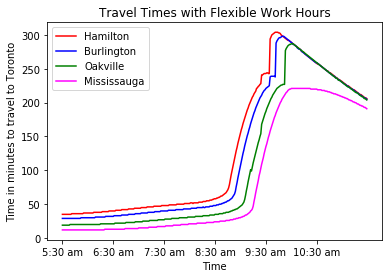

In [4]:
travel_times = [[get_travel_time(ind,start_time) for start_time in range(0,360)] for ind in range(len(roads))]

print(travel_times[0][100])
print(travel_times[1][115])
print(travel_times[2][135])
print(travel_times[3][155])

plt.title("Travel Times with Flexible Work Hours")
plt.xlabel("Time")
plt.ylabel("Time in minutes to travel to Toronto")
plt.xticks((np.arange(0,360,60)),('5:30 am','6:30 am','7:30 am','8:30 am','9:30 am','10:30 am'))

plot(travel_times[0], color='red') 
plot(travel_times[1], color='blue') 
plot(travel_times[2], color='green')
plot(travel_times[3], color='magenta')

plt.legend(('Hamilton','Burlington','Oakville','Mississauga'))

show()

## Conclusions

These results look good. There is a lot of chaos in the model because once Mississauga gets backed up, the flow and speed of the previous road sections get messy. 

### Remaining Issues

- There is still a slight problem with the model though: If there is a backup in the next section, the average speed doesn't decrease to zero, only the speed just before the next road section. In other words, for some drivers the speed is zero, but on average people near the start of the road would still be driving.

- When a road is jammed, the on ramp traffic is still disappearing, assumed to find a different way to get to work.